In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.api import OLS

%matplotlib inline

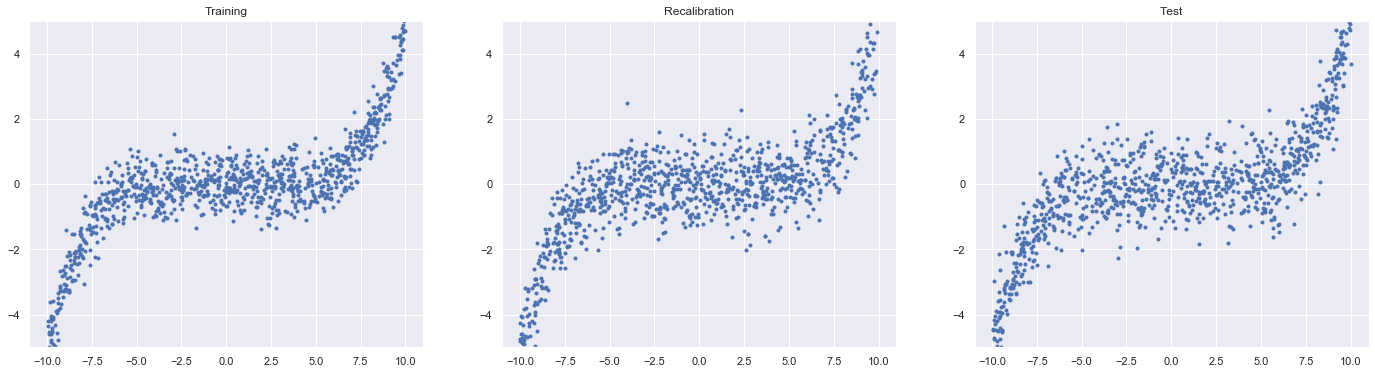

In [5]:
n = 4000
n_per = 1000
x = np.linspace(-10, 10, n)
y = 0.00005*x**5 + np.random.normal(scale=0.5,size=n)

# eval and test dataset
x, x_test, y, y_test = train_test_split(x,y,train_size=0.5)
x, x_eval, y, y_eval = train_test_split(x,y,train_size=0.5)
x_test, y_test = x_test[0:n_per], y_test[0:n_per]

# adding some noise
y_eval += np.random.normal(scale=0.5,size=n_per)
y_test += np.random.normal(scale=0.5,size=n_per)

# sorting
inds_x, inds_eval, inds_test = np.argsort(x), np.argsort(x_eval), np.argsort(x_test)
x, y = x[inds_x], y[inds_x]
x_eval, y_eval = x_eval[inds_eval], y_eval[inds_eval]
x_test, y_test = x_test[inds_test], y_test[inds_test]

assert x.shape == x_eval.shape and x_eval.shape == x_test.shape and x_test.shape[0] == n_per

# plotting x and y
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6))

# training
ax[0].plot(x, y, 'o', markersize=3)
ax[0].set_title('Training')
ax[0].set_ylim([-5,5])

# eval
ax[1].plot(x_eval, y_eval, 'o', markersize=3)
ax[1].set_title('Recalibration')
ax[1].set_ylim([-5,5])

# test
ax[2].plot(x_test, y_test, 'o', markersize=3)
ax[2].set_title('Test')
ax[2].set_ylim([-5,5]);

### Statsmodels

(1000, 16)
89.1% of the points in the 95% PI


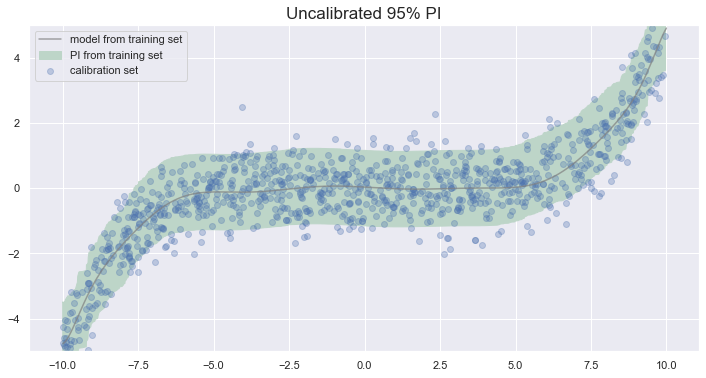

In [6]:
poly_x_const = lambda x: sm.add_constant(PolynomialFeatures(15).fit_transform(x.reshape(-1,1)))
print(poly_x_const(x).shape)

sm_model = OLS(y, poly_x_const(x)).fit()
df = sm_model.get_prediction().summary_frame(alpha=0.025)

y_preds_sm = sm_model.predict(poly_x_const(x))

upper_pi_sm = df.obs_ci_upper
lower_pi_sm = df.obs_ci_lower

perc_within = np.mean((y_eval <= upper_pi_sm)&(y_eval >= lower_pi_sm))
print(f'{perc_within*100:.1f}% of the points in the 95% PI')

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.fill_between(x_eval, y1=lower_pi_sm, y2=upper_pi_sm, color='#BDD5C8', label='PI from training set')
ax.scatter(x_eval, y_eval, alpha=0.3, label='calibration set')
ax.plot(x, y_preds_sm, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_ylim([-5,5])
ax.set_title('Uncalibrated 95% PI', fontsize=17);

,x_eval,y_eval,h_xt_yt_sm,P_hat_sm
0,-10.000000,-4.267095,0.525250,0.587
1,-9.994999,-5.258026,0.473837,0.465
2,-9.974994,-4.749991,0.497940,0.525
3,-9.969992,-4.804763,0.493400,0.511
4,-9.949987,-6.565808,0.332375,0.146


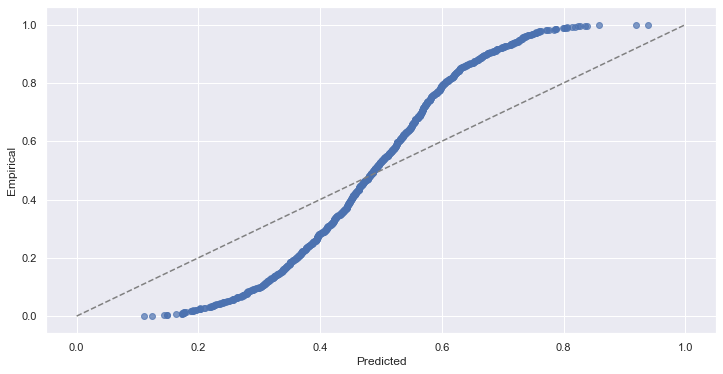

In [7]:
h_xt_yt_sm = st.norm.cdf(y_eval, loc=df['mean'], scale=df['mean_se']*(np.sqrt(n_per)))

P_hat_sm = np.zeros(len(h_xt_yt_sm))
for i, p in enumerate(h_xt_yt_sm):
    P_hat_sm[i] = np.sum(h_xt_yt_sm <= p)/len(h_xt_yt_sm)

results = pd.DataFrame({'x_eval':x_eval, 'y_eval':y_eval, 'h_xt_yt_sm':h_xt_yt_sm, 'P_hat_sm':P_hat_sm})
results = results[['x_eval','y_eval','h_xt_yt_sm','P_hat_sm']]
display(results.head())

calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(h_xt_yt_sm, P_hat_sm)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(h_xt_yt_sm, P_hat_sm, alpha=0.7)
ax.plot([0,1],[0,1],'--', color='grey')
ax.set_xlabel('Predicted')
ax.set_ylabel('Empirical');

[0.001   0.99999]


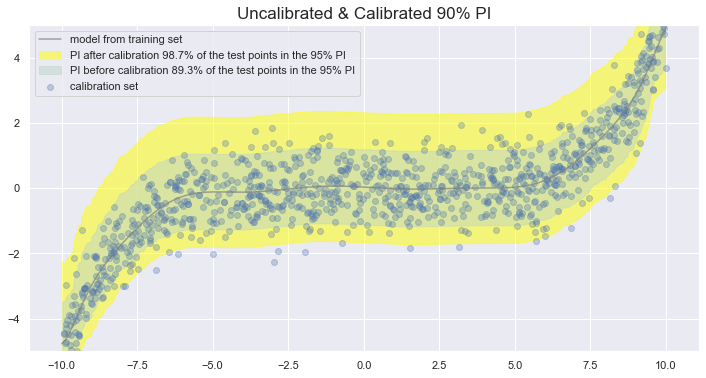

In [8]:
new_quantiles = np.clip(calibrator.predict([0.025, 0.975]), -1e-5, 1-1e-5)
print(new_quantiles)

# PI
lower_pi_cal_sm = sm_model.get_prediction().summary_frame(alpha=new_quantiles[0]).obs_ci_lower
upper_pi_cal_sm = sm_model.get_prediction().summary_frame(alpha=1-new_quantiles[1]).obs_ci_upper

perc_within_before = np.mean((y_test <= upper_pi_sm)&(y_test >= lower_pi_sm))
before = f'{perc_within_before*100:.1f}% of the test points in the 95% PI'

perc_within_after = np.mean((y_test <= upper_pi_cal_sm)&(y_test >= lower_pi_cal_sm))
after = f'{perc_within_after*100:.1f}% of the test points in the 95% PI'

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_ylim([-5,5])
ax.fill_between(x_test, y1=lower_pi_cal_sm, y2=upper_pi_cal_sm, color='yellow', 
                label=f'PI after calibration {after}', alpha=0.5)
ax.fill_between(x_test, y1=lower_pi_sm, y2=upper_pi_sm, color='#BDD5C8', 
                label=f'PI before calibration {before}', alpha=0.5)
ax.scatter(x_test, y_test, alpha=0.3, label='calibration set')
ax.plot(x, y_preds_sm, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_title('Uncalibrated & Calibrated 90% PI', fontsize=17);

### Boostrapping using Sklearn

In [9]:
# bootstrap when doing CDF
n_boots = 1000

boot_preds = np.zeros(shape=(n_boots, len(x_eval)))

for i in range(n_boots):
    x_, y_ = resample(x_eval, y_eval)
    
    # instantiate model and feature preprocessing objects
    model = LinearRegression()
    poly = PolynomialFeatures(10)
    # preprocess data
    x_ = poly.fit_transform(x_.reshape(-1,1))
    # fit
    model.fit(x_, y_)
    # preprocess features to evaluate
    x_eval_ = poly.transform(x_eval.reshape(-1,1))
    # predict
    preds = model.predict(x_eval_)
    # store bootstrapped predictions
    boot_preds[i,:] = preds

(1000, 11) (1000,)
12.5% of the points in the 90% PI


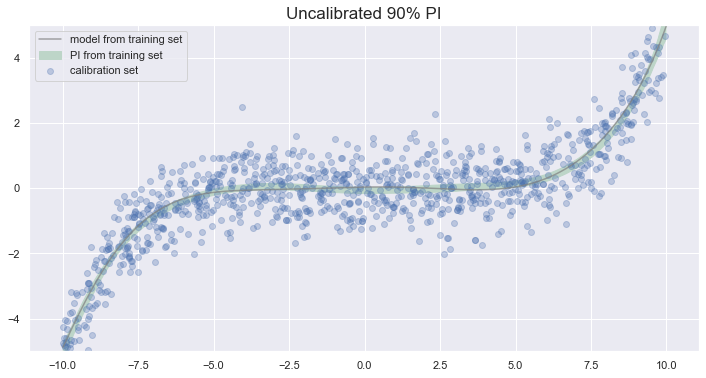

In [10]:
# point estimate
model = LinearRegression()
x_poly = poly.transform(x.reshape(-1,1))
model.fit(x_poly, y)
y_preds = model.predict(x_poly)
print(x_poly.shape, y_preds.shape)

# PI
lower_pi = np.percentile(boot_preds, 5, axis=0)
upper_pi = np.percentile(boot_preds, 95, axis=0)

perc_within = np.mean((y_eval <= upper_pi)*(y_eval >= lower_pi))
print(f'{perc_within*100:.1f}% of the points in the 90% PI')

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.fill_between(x_eval, y1=lower_pi, y2=upper_pi, color='#BDD5C8', label='PI from training set')
ax.scatter(x_eval, y_eval, alpha=0.3, label='calibration set')
ax.plot(x, y_preds, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_ylim([-5,5])
ax.set_title('Uncalibrated 90% PI', fontsize=17);

In [11]:
# calibrate this now
x_eval_ = poly.fit_transform(x_eval.reshape(-1,1))
h_xt_yt = np.mean(boot_preds <= model.predict(x_eval_), axis=0)

P_hat = np.zeros(len(h_xt_yt))
for i, p in enumerate(h_xt_yt):
    P_hat[i] = np.sum(h_xt_yt <= p)/len(h_xt_yt)
    
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(h_xt_yt, P_hat)

results = pd.DataFrame({'X':x_eval, 'y':y_eval, 'h_xt_yt':h_xt_yt, 'P_hat':P_hat})
results = results[['X','y','h_xt_yt','P_hat']]
results.head()

,X,y,h_xt_yt,P_hat
0,-10.000000,-4.267095,0.657,0.580
1,-9.994999,-5.258026,0.661,0.588
2,-9.974994,-4.749991,0.663,0.590
3,-9.969992,-4.804763,0.664,0.592
4,-9.949987,-6.565808,0.672,0.604


(1000,) (1000,)
0.657 0.801


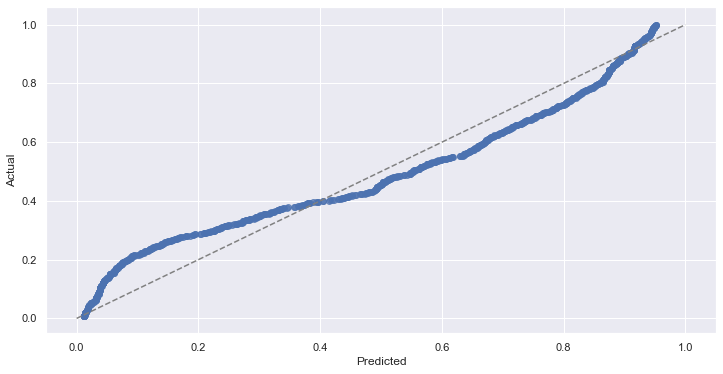

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(h_xt_yt, P_hat, alpha=0.7)
ax.set_xlabel('Predicted')
ax.plot([0,1],[0,1],'--', color='grey')
ax.set_ylabel('Actual');

x_poly_test = poly.transform(x_test.reshape(-1,1))
h_xte_yte = np.mean(boot_preds <= model.predict(x_poly_test), axis=0)
print(h_xt_yt.shape, h_xte_yte.shape) # should be the same
print(h_xt_yt[0], h_xte_yte[0]) # should be different

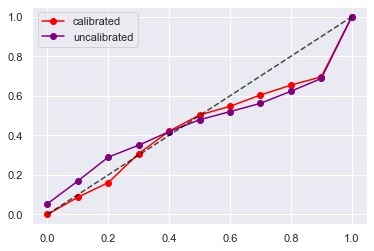

In [13]:
predicted_values = h_xte_yte
expected_values = np.linspace(0, 1, num=11).reshape(-1, 1)
calibrated_values = calibrator.predict(predicted_values)

observed_uncalibrated = np.mean(predicted_values.reshape(1, -1) <= expected_values, axis=1) 
observed_calibrated = np.mean(calibrated_values.reshape(1, -1) <= expected_values, axis=1) 

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(expected_values, observed_calibrated, 'o-', color='red', label='calibrated')
ax.plot(expected_values, observed_uncalibrated, 'o-', color='purple', label='uncalibrated')
ax.plot([0,1],[0,1], '--', color='black', alpha=0.7)
ax.legend();

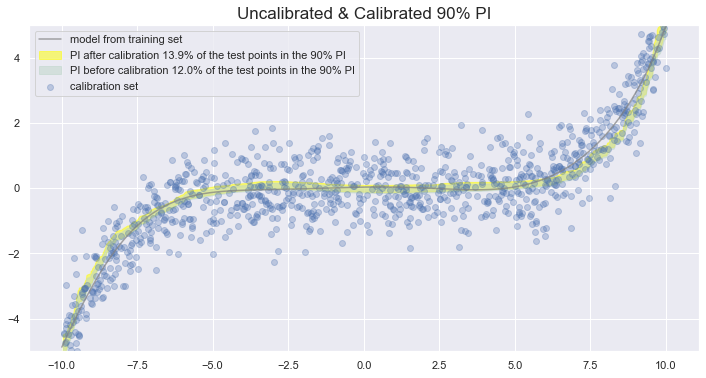

In [14]:
new_quantiles = calibrator.transform([0.05, 0.95])
    
# PI
lower_pi_cal = np.percentile(boot_preds, 100*new_quantiles[0], axis=0)
upper_pi_cal = np.percentile(boot_preds, 100*new_quantiles[1], axis=0)

perc_within_before = np.mean((y_test <= upper_pi)*(y_test >= lower_pi))
before = f'{perc_within_before*100:.1f}% of the test points in the 90% PI'

perc_within_after = np.mean((y_test <= upper_pi_cal)*(y_test >= lower_pi_cal))
after = f'{perc_within_after*100:.1f}% of the test points in the 90% PI'

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.set_ylim([-5,5])
ax.fill_between(x_test, y1=lower_pi_cal, y2=upper_pi_cal, 
                color='yellow', label=f'PI after calibration {after}', alpha=0.5)
ax.fill_between(x_test, y1=lower_pi, y2=upper_pi, 
                color='#BDD5C8', label=f'PI before calibration {before}', alpha=0.5)
ax.scatter(x_test, y_test, alpha=0.3, label='calibration set')
ax.plot(x, y_preds, color='grey', alpha=0.7, label='model from training set')
ax.legend(loc='upper left')
ax.set_title('Uncalibrated & Calibrated 90% PI', fontsize=17);

---